<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "5A"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/5A/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


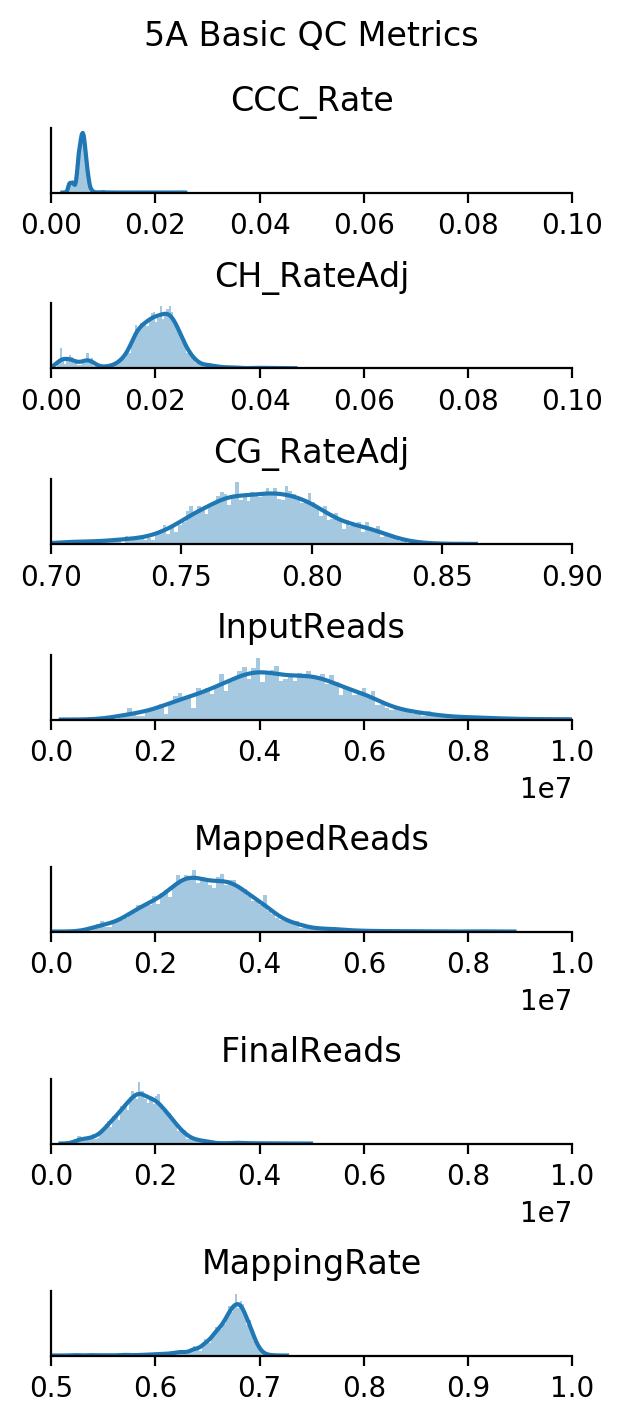

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

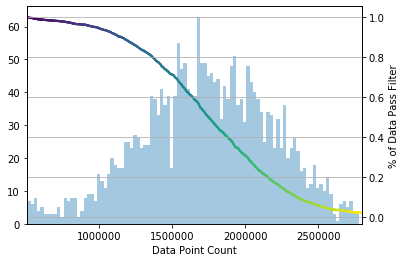

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2367/2367 (100.0%)
CG_RateAdj passed 2367/2367 (100.0%)
CH_RateAdj passed 2367/2367 (100.0%)
FinalReads passed 2367/2367 (100.0%)
MappingRate passed 2367/2367 (100.0%)
Overall passed 2367/2367 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
190205 1243
190307 1124


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 296 77.1%
ad002 303 78.9%
ad004 298 77.6%
ad006 291 75.8%
ad007 286 74.5%
ad008 300 78.1%
ad010 290 75.5%
ad012 303 78.9%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
5A_M_0,/gale/raidix/rdx-4/mapping/5A/CEMBA190205-5A-1...,0.006411,0.818809,0.817640,0.031758,0.025511,1098777.0,2549332,1739477.0,5A,...,-21.917549,0.791903,-33.452315,-9.721839,MGE-Sst Frmd6,-0.198795,-12.675573,-3.181399,20.060181,True
5A_M_1,/gale/raidix/rdx-4/mapping/5A/CEMBA190205-5A-1...,0.006551,0.788103,0.786705,0.031735,0.025350,1531902.0,3598792,2464946.0,5A,...,8.837035,9.677595,51.965309,19.999829,PT-L5 Tenm2,-14.468501,7.426837,-9.479703,0.492682,True
5A_M_10,/gale/raidix/rdx-4/mapping/5A/CEMBA190205-5A-1...,0.006594,0.805427,0.804136,0.029709,0.023268,1825527.0,4306118,2841528.0,5A,...,25.750750,8.649310,-15.767301,-29.701484,CT-L6 Il1rap,-1.636711,-22.094992,-17.272684,-24.398675,True
5A_M_100,/gale/raidix/rdx-4/mapping/5A/CEMBA190205-5A-1...,0.005938,0.837179,0.836206,0.027026,0.021215,686815.0,1918794,1155111.0,5A,...,27.464134,0.163500,-7.045574,-31.357430,NP-L6 Kcnab1,5.258320,-7.199080,17.714047,13.194135,True
5A_M_1000,/gale/raidix/rdx-4/mapping/5A/CEMBA190205-5A-3...,0.005876,0.772475,0.771130,0.024701,0.018937,2226590.0,6205658,4209670.0,5A,...,6.297309,-12.122645,-1.738632,26.168880,IT-L5 Cdh8,-2.793143,9.772094,41.736763,1.054278,True
5A_M_1001,/gale/raidix/rdx-4/mapping/5A/CEMBA190205-5A-3...,0.005826,0.752739,0.751290,0.022792,0.017066,1238866.0,3609444,2339237.0,5A,...,1.102369,-9.187021,-21.957085,23.175481,IT-L23 Tenm2,2.203568,-0.577322,6.200700,39.266763,True
5A_M_1002,/gale/raidix/rdx-4/mapping/5A/CEMBA190205-5A-3...,0.007151,0.778372,0.776776,0.031927,0.024954,1739621.0,4794486,3306312.0,5A,...,12.869156,-9.802688,25.192008,3.701809,IT-L5 Grik3,7.401950,-0.911618,-18.430389,34.739089,True
5A_M_1003,/gale/raidix/rdx-4/mapping/5A/CEMBA190205-5A-3...,0.005880,0.764351,0.762957,0.022454,0.016672,1218706.0,3546960,2307730.0,5A,...,0.848338,-9.072584,-25.081156,26.593116,IT-L23 Tenm2,2.345198,-1.041300,5.875981,36.559574,True
5A_M_1004,/gale/raidix/rdx-4/mapping/5A/CEMBA190205-5A-3...,0.006743,0.811088,0.809805,0.028779,0.022185,1775246.0,4919052,3393453.0,5A,...,25.736826,6.395818,-14.139548,-21.089904,CT-L6 Megf9,-0.312726,-21.250456,-8.480868,-33.954923,True
5A_M_1005,/gale/raidix/rdx-4/mapping/5A/CEMBA190205-5A-3...,0.006785,0.785289,0.783823,0.029090,0.022458,1757058.0,4841994,3338061.0,5A,...,10.186550,-11.198672,20.154288,33.331624,IT-L5 Etv1,2.746746,4.774582,2.748173,2.099070,True
